<a href="https://colab.research.google.com/github/bar181/CSCI-E25/blob/master/1_WorkingWithImageData_Bradley_Ross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI E-25      
## Working with Image Data  
### Steve Elston

## Introduction   

This lesson will familarize you with the basic concepts of working with image data and some statistical properties of images. Some key points are of this lesson are:     
1. Discrete pixel structure of digital images.    
2. Representation of color and gray scale images.   
3. Intensity distribution of image data.
4. Equalizing intensity distributions and improving contrast.
5. Resizing images.


## Importing Packages

As a first step, you will now import the required Python packages.

> **Scikit-Image:** In this lesson, and for much of the rest of this course, we will be using the Scikit-Learn Image package. This package provides many commonly used computer vision algorithms using a consistent Python API. This package follows the API conventions of Scikit-Learn, enabling the application of a rich library of machine learning algorithms. There is excellent documentation available for the [Scikit-Learn Image package](https://scikit-image.org/docs/stable/index.html). You may wish to start by reading through the [User Guide](https://scikit-image.org/docs/stable/user_guide/index.html). Examples of what you can do with Scikit-Learn Image package can be seen in the [Gallery](https://scikit-image.org/docs/stable/auto_examples/index.html).    
>
> **Scikit-Image and Numpy:** Like all Scikit packages Scikit-Image is built on [Numpy](https://numpy.org/). If you are not very familiar with Numpy there is an ReviewOfLinearAlgebra Jupyter notebook under the SuplementaryMaterial directory in the course GitHub repository, or you can find Tutorials [here](https://numpy.org/numpy-tutorials/). A tutorial on using Numpy with Scikit-learn image data objects can be found [here](https://scikit-image.org/docs/stable/user_guide/numpy_images.html).



To run the code in this notebook you will need to have Scikit-Image installed in your envrionment. If you do not have Scikit-Image installed, you can uncomment and execute the code in the cell below. You can find [full instalation instructions here](https://scikit-image.org/docs/stable/user_guide/install.html).  

In [2]:
%pip install scikit-image

To get started with this lesson, execute the code in the cell below to import the packages you will need. `

In [3]:
import skimage
from skimage import data
from skimage.filters.rank import equalize, threshold
import skimage.filters as skfilters
from skimage import exposure
from skimage.morphology import disk, square
from skimage.color import rgb2gray, rgb2ycbcr, ycbcr2rgb, rgb2xyz, xyz2rgb, rgb2yuv, yuv2rgb, rgb2hsv, hsv2rgb
from skimage.measure import block_reduce
from skimage.transform import resize
from skimage.util import img_as_ubyte
import numpy as np
import numpy.random as nr
from PIL import Image
from scipy import signal
import cv2 as cv
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Structure of a Color Image Object

The code in the cell below loads a color image of a human retina, prints the data types and dimensions of the image object, and displays the image. The image is displayed by [matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html). Execute the code and examine the result.

The image object is <class 'numpy.ndarray'>
The pixel values are of type <class 'numpy.uint8'>
Shape of image object = (1411, 1411, 3)


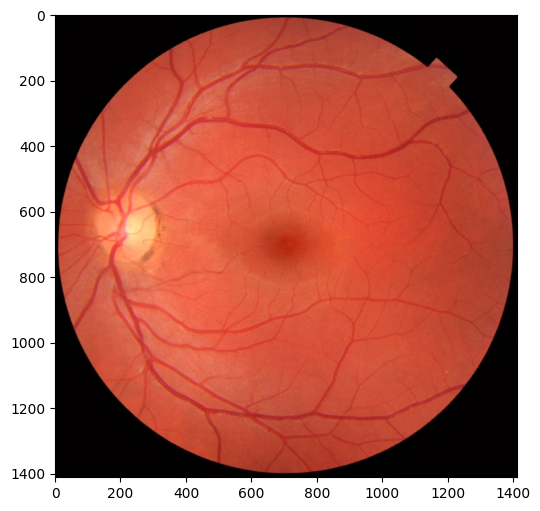

In [4]:
retina_image = data.retina()
print('The image object is ' + str(type(retina_image)))
print('The pixel values are of type ' + str(type(retina_image[0,0,0])))
print('Shape of image object = ' + str(retina_image.shape))
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(retina_image)

The image object has 3-dimensions, the two spatial dimensions and the 3 color channels. Examine this image noticing the wide variation in color and intensity. Notice also that the illumination of the retina does not appear uniform, resulting in a bright spot on the left and a darker region on the right.  

> **Exercise 1-1:** Complete the code for the function in the cell below to display the 3 color channels of the image and the original image in a 2x2 array using the [matplotlib.pyplot.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function. The color channels are in red, green, blue order and should be displayed as gray scale using the `cmap=plt.get_cmap('gray')` argument. Your function should label the channels and the original image. Execute your function and examine the results.    

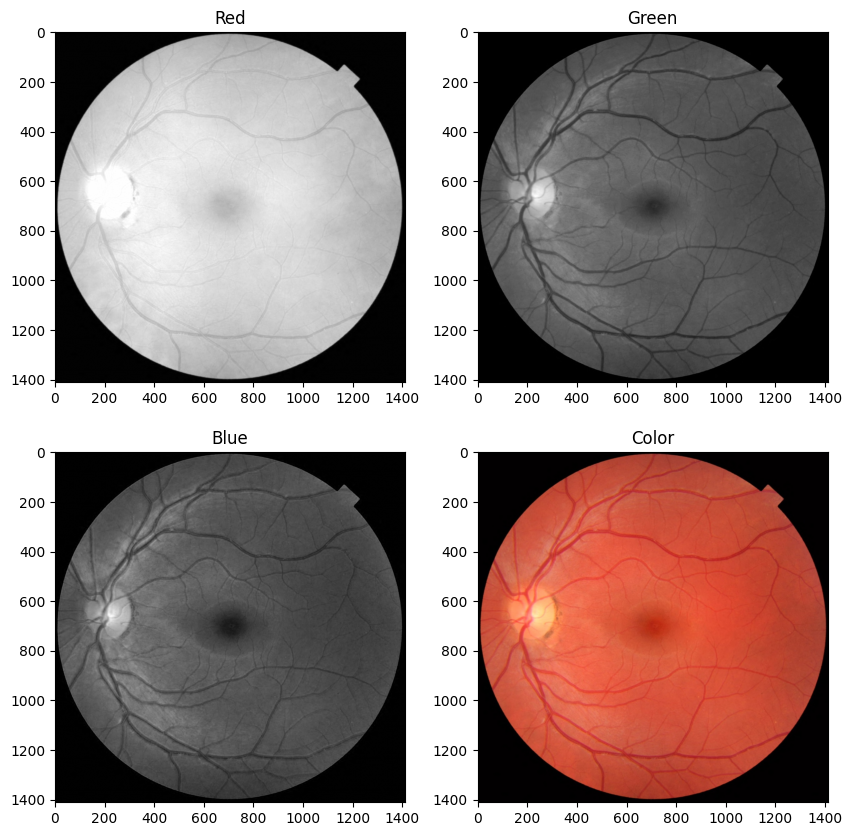

In [19]:
def plot_3_color_channels(img, titles=['Red','Green','Blue','Color'], plot_image=True):
    '''Function plots the three color channels of the image along with the complete image'''
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    ax = ax.flatten()
    ## Complete the code below

    # Set title
    for i in range(4):
        ax[i].set_title(titles[i])

    # Get the color channels
    red_channel = img[:, :, 0]   # Extract Red channel - last item is array
    green_channel = img[:, :, 1]
    blue_channel = img[:, :, 2]

    # Plot channel
    # ax[0].imshow(red_channel, cmap=plt.get_cmap('gray'))  # red converted to gray scale
    ax[0].imshow(red_channel, cmap='gray')  # red converted to gray scale - alternative way
    ax[1].imshow(green_channel, cmap='gray')
    ax[2].imshow(blue_channel, cmap='gray')
    ax[3].imshow(img)

plot_3_color_channels(retina_image)

> Examine the intensity (brightness) of the color channels and answer these questions:    
> 1. Which channel has the greatest intensity, and does this make sense given the image?      
> 2. Is it likely that the saturation of the red channel arises as an artifact of the illumination spot on the left of the retina image?      
> **End of exercise.**



> **Answers:**     
>    1. Red.  Makes sense as the source image is mainly red (blood vessels are similar color to rest of image)     
>    2. No. The high amount of red is likely due to the composition of the retina. The bright spot in the left amplifies but is not the main reason for the red saturation     

When working with digital images it is always important to keep in mind the discrete nature of the samples. To demonstrate the discrete nature of a digital image you can visualize a 100 pixel, or $10 \times 10$, sample from the larger image by executing the code in the cell below.

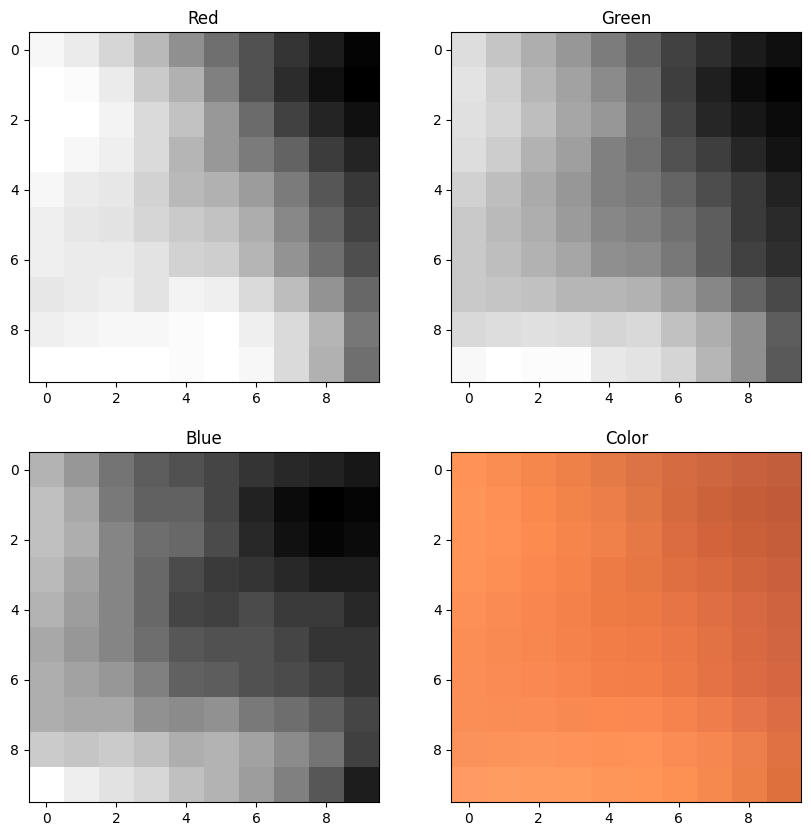

In [20]:
plot_3_color_channels(retina_image[600:610,300:310,:])

Notice the discrete nature in each of the three color channels and the color image. The sum of these discrete color-channel pixel intensities yields the color image.    

## Statistical Properties of an Image  

The next question is, what is the distribution of pixel intensities in the 3 color channels of the image? Histograms and cumulative density functions are used to analyze these distributions. The code in the cell below plots the histograms of the 3 color channels along with their cumulative distributions. Execute this code and examine the results.    

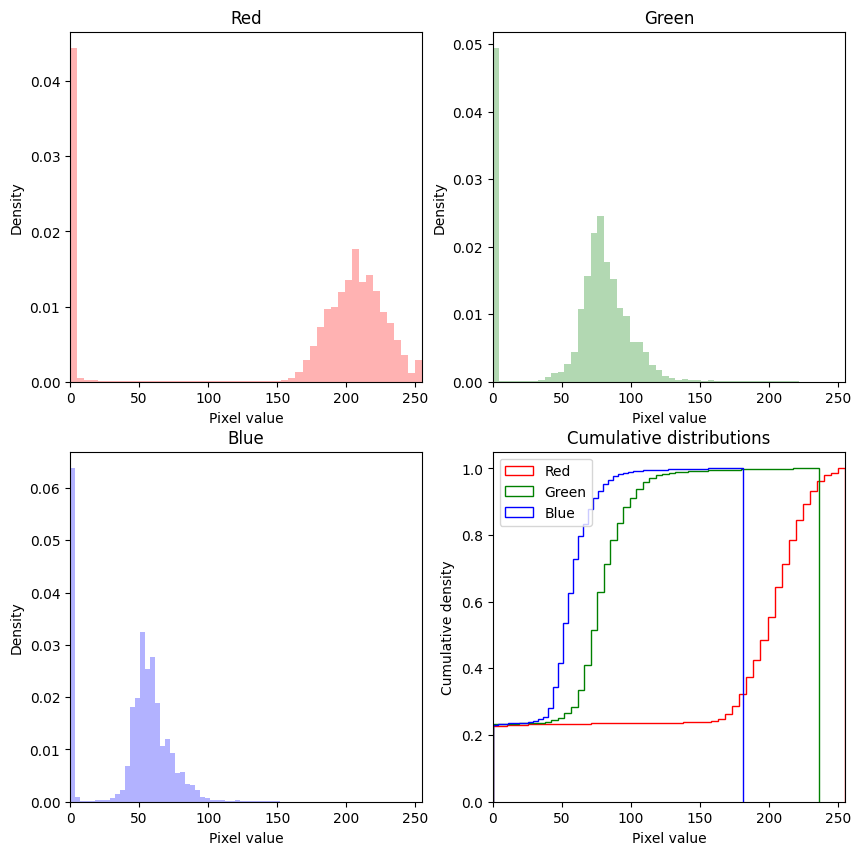

In [21]:
def plot_image_distributions(img, xlim=(0,255)):
    '''Function plots histograms of the three color channels of the image along
    with the cumulative distributions'''
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    ax = ax.flatten()
    titles=['Red','Green','Blue']
    for i in range(3):
        ax[i].hist(img[:,:,i].flatten(), bins=50, density=True, color=titles[i], alpha=0.3)
        ax[i].set_title(titles[i])
        ax[i].set_xlabel('Pixel value')
        ax[i].set_ylabel('Density')
        ax[i].set_xlim(xlim)
        ax[3].hist(img[:,:,i].flatten(), bins=50, density=True, cumulative=True, color=titles[i], histtype='step', label=titles[i])
        ax[3].set_xlim(xlim)
    ax[3].set_title('Cumulative distributions')
    ax[3].set_xlabel('Pixel value')
    ax[3].set_ylabel('Cumulative density')
    plt.legend(loc='upper left')

plot_image_distributions(retina_image)

There are several properties of the distribution of the pixel values which are important:     
1. The distribution of the intensity for of the red channel has clearly higher values than the other channels.    
2. A significant fraction of pixel values have 0 intensity for all 3 color channels. These pixels are primarily black background around the retina, but may also represent the dark pupil spot in the center of the retina.   
3. A few red channel pixels have the maximum value of 255. The red intensity of these pixels is said to be **saturated**.      

## Improving Contrast     

Our next question to address is what is the ideal distribution of the intensity values of an image? A useful, and obviously answer, is that we want the pixel values over the full range of possible values. For unsigned integer values, {0,255}. Further, the distribution of pixel values should be uniform. For the $n=256$ unsigned integer values the **probability mass function**, or **PMF**, of the $ith$ value is:     

$$p(i) = \frac{1}{n}$$      

And the **cumulative density function**, or **CDF**, of the uniform distribution at the $ith$ value is, $x_i$:   

$$CDF(i) = \sum_{i=0}^{n-1} \frac{1}{x_i}$$  

We can visualize an example of a gray-scale image of unsigned integers on the range {0,255} with random uniform distributed pixel values. The code in the cell below forms a gray-scale image randomly sampled uniform distributed pixel values and displays the result.               

(1411, 1411)


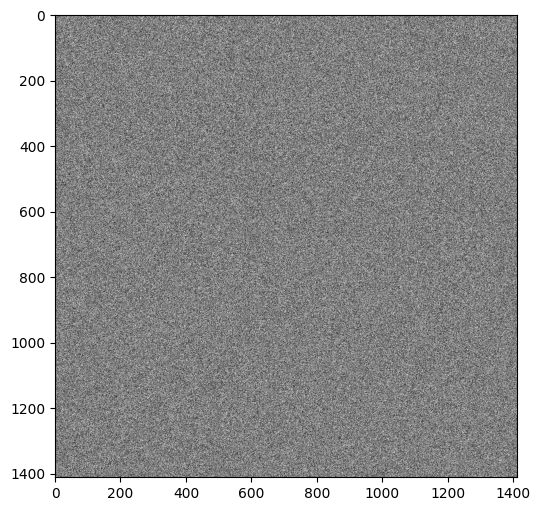

In [22]:
random_image = np.multiply((nr.uniform(low=0.0, high=255.0, size=retina_image.shape[0]*retina_image.shape[1])), 255).reshape((retina_image.shape[0], retina_image.shape[1]))
random_image = random_image.astype(np.uint8)
print(random_image.shape)
fig, ax = plt.subplots( figsize=(6, 6))
_=ax.imshow(random_image, cmap=plt.get_cmap('gray'))

To view the distribution of the pixel values of this image execute the code in the cell below.

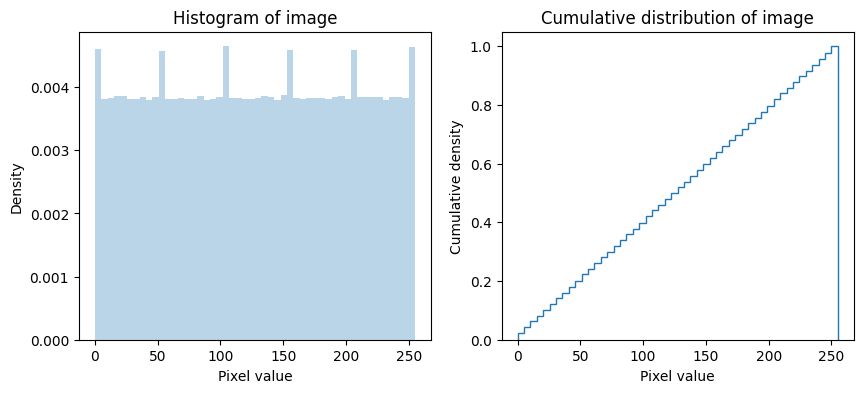

In [23]:
def plot_gray_scale_distribution(img):
    '''Function plots histograms a gray scale image along
    with the cumulative distribution'''
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    ax[0].hist(img.flatten(), bins=50, density=True, alpha=0.3)
    ax[0].set_title('Histogram of image')
    ax[0].set_xlabel('Pixel value')
    ax[0].set_ylabel('Density')
    ax[1].hist(img.flatten(), bins=50, density=True, cumulative=True, histtype='step')
    ax[1].set_title('Cumulative distribution of image')
    ax[1].set_xlabel('Pixel value')
    ax[1].set_ylabel('Cumulative density')
    plt.show()

plot_gray_scale_distribution(random_image)

> **Exercise 1-2:** To compare the pixel value distribution of the retina image to the ideal values do the following:   
> 1. Create a gray-scale image object named `retina_gray_scale` using the [skimage.color.rgb2gray](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html) function.
> 2. Print the dimensions of the image object.  
> 3. Display the gray-scale image. Make sure the image is large enough to see the details.   
> 4. Plot the distribution of the pixel values of the gray-scale image.

step 2 dimensions of retina_gray_scale (1411, 1411)


step 3 gray-scale image


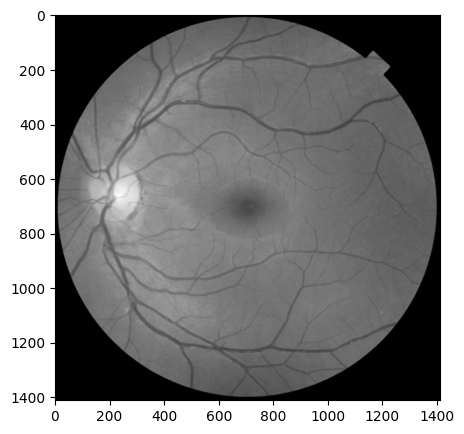



step 4 distribution


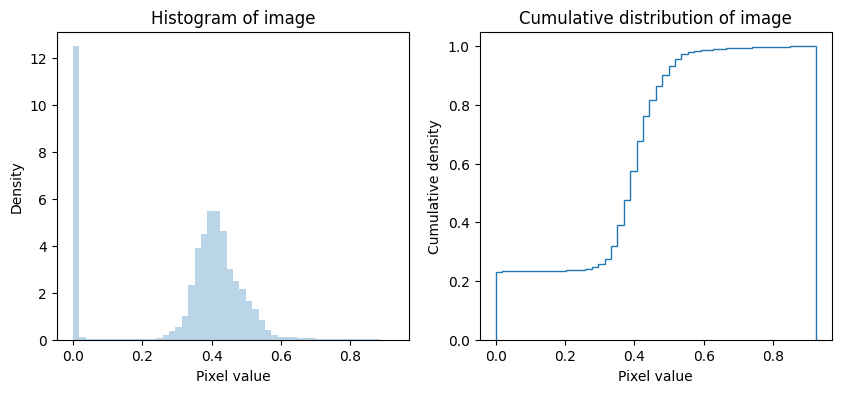

In [33]:
def plot_grayscale(img):
    fig, ax = plt.subplots( figsize=(5, 5))
    _=ax.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

## Put you code below
# step 1 gray-scale image object
retina_gray_scale = rgb2gray(retina_image)

# step 2 Print the dimensions of the image object
print("step 2 dimensions of retina_gray_scale", retina_gray_scale.shape)
print("\n")

# step 3 Display the gray-scale image. Make sure the image is large enough to see the details
print("step 3 gray-scale image")
plot_grayscale(retina_gray_scale)
print("\n")

# step 4 Plot the distribution of the pixel values of the gray-scale image
print("step 4 distribution")
plot_gray_scale_distribution(retina_gray_scale)

> Examine the distribution plots and answer these questions:  
> 1. How would you describe these results with respect to the ideal distribution?    
> 2. How do you think the range of pixel values limit the contrast of the image?     
> **End of exercise.**

> **Answer:**
> 1.   Not ideal as high concentration of black (0) and not spread out.  An ideal image would have a more flat distrubution
> 2.  An ideal image would show more differences and better contrast.  Because this image has a distribution within a narrow range the contrast is limited   

## Histogram Equalization

**Contrast** of an image is range between the minimum and maximum pixel values of an image. The larger the range of values the more distinctive the differences in the image will be. To improve the contrast in an image we need to **equalize** the pixel values over the maximum of the range. The goal is to find a transformation that stretches the pixel values into a uniform distribution. This process is know as **histogram equalization**.    

Histogram equalization can be performed in a number of ways. The obvious algorithm is global histogram equalization. The pixel values are transformed to equalize the histogram across the entire image. However, if illumination is inconsistent across the image, global equalization will not be optimal. An alternative is to perform local histogram equalization over small areas of the image. This method is known as **adaptive histogram equalization**. Adaptive equalization can compensate for uneven illumination across the image.           

> **Exercise 1-3:** You will now apply both common types of histogram equalization to the gray-scale retina image. The code in the cell belpw uses both the [skimage.exposure.equalize_hist](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html) function and the [skimage.exposure.equalize_adapthist](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist) function. Additionally, the code tests different clip limits for the adaptive histogram equalization, $[0.01,0.02,0.1]$, and with a patch size of $8 \times 8$. A clip limit of $0.01$ is the the default value. The code in the cell does the following for each funciton and arguments:    
> 1. Executes the equalization function passed as an argument. Pass the function name and arguments as strings using the Python [eval](https://www.w3schools.com/python/ref_func_eval.asp) function.  
> 2. Display the equalized gray-scale image using the `plot_grayscale()` function.   
> 3. Plot the distribution of the pixel values of the equalized gray-scale image using the `plot_gray_scale_distribution()` function.    
>
> Execute the code in the cell below.


For function equalize_hist 


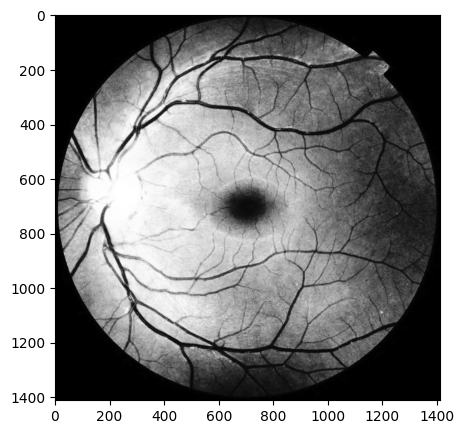

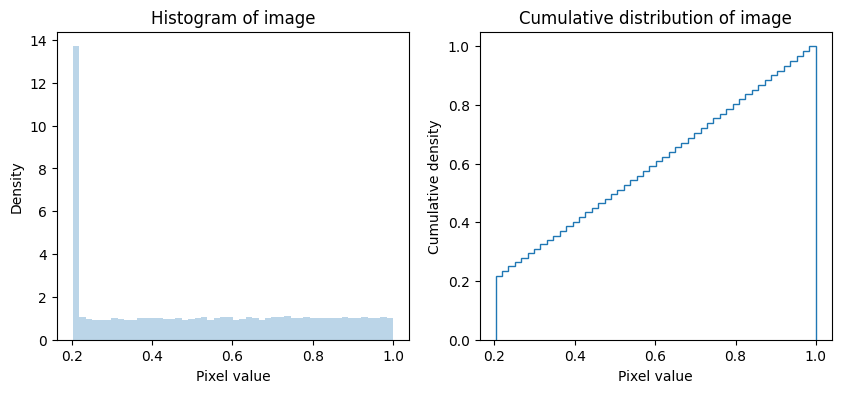


For function equalize_adapthist {"clip_limit": 0.01, "kernel_size": 12}


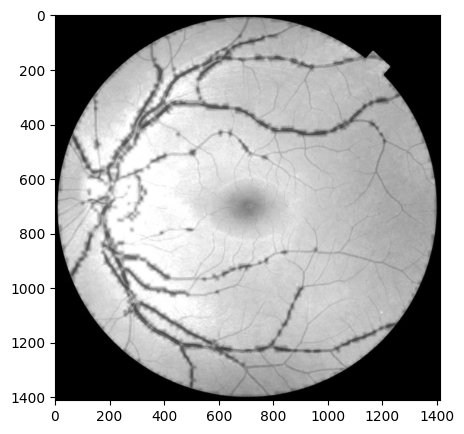

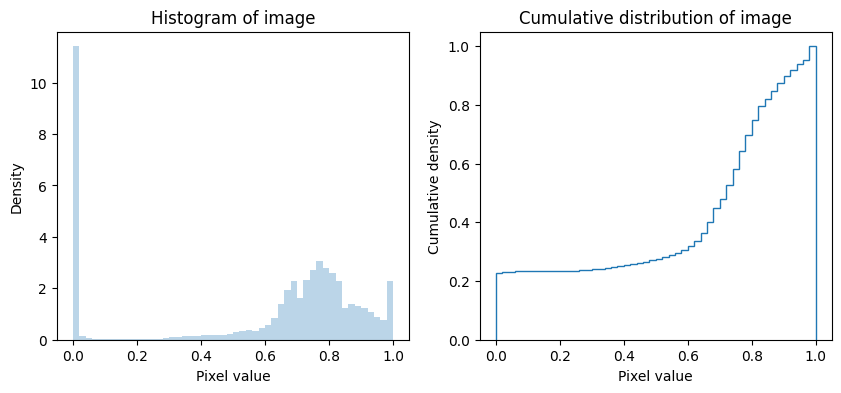


For function equalize_adapthist {"clip_limit": 0.03, "kernel_size": 12}


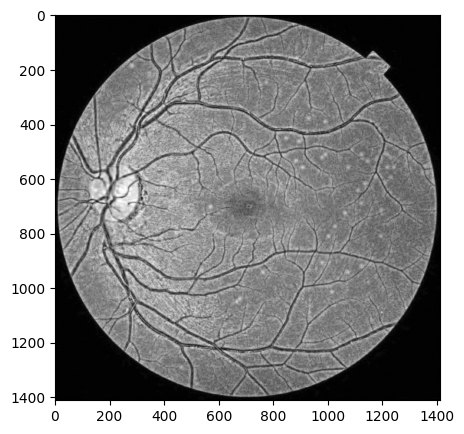

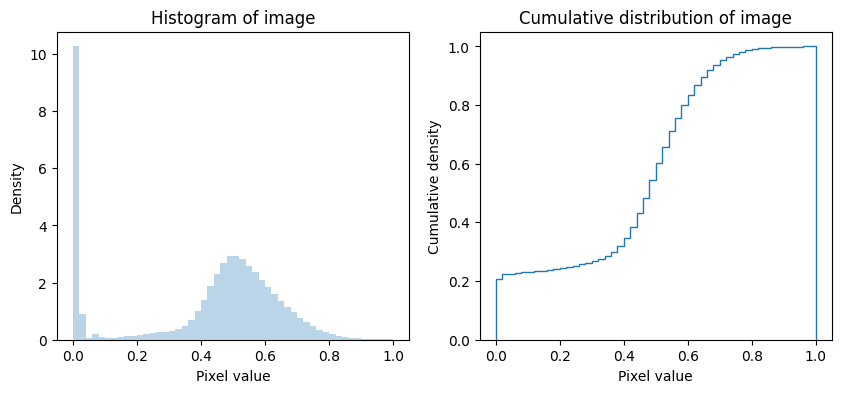


For function equalize_adapthist {"clip_limit": 0.1, "kernel_size": 12}


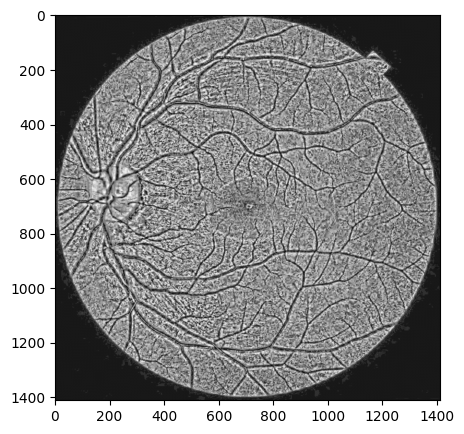

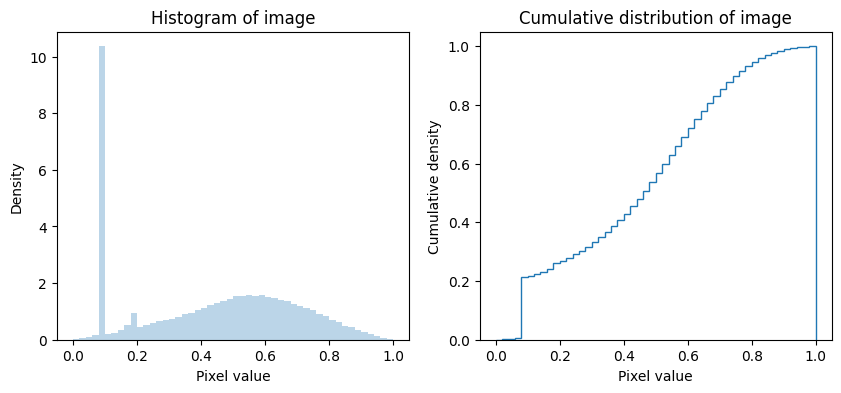

In [34]:
import json

def test_equalize(img, func, **kwargs):
    img_equalized = func(img, **kwargs)
    plot_grayscale(img_equalized)
    plot_gray_scale_distribution(img_equalized)
    return img_equalized

equalize_list = [
    exposure.equalize_hist,
    exposure.equalize_adapthist,
    exposure.equalize_adapthist,
    exposure.equalize_adapthist
]

args_list = [
    None,
    {'clip_limit': 0.01, 'kernel_size': 12},
    {'clip_limit': 0.03, 'kernel_size': 12},
    {'clip_limit': 0.1, 'kernel_size': 12},
]

for func, kwargs in zip(equalize_list, args_list):
    print('\nFor function ' + func.__name__ + ' ' + (json.dumps(kwargs) if kwargs else ''))

    retina_gray_scale_equalized = \
        test_equalize(retina_gray_scale, func, **kwargs) if kwargs \
        else test_equalize(retina_gray_scale, func)

> Answer the following questions:  
> 1. Compare the unequalized and equalized imagess. What aspects of the of the images are more apparent with the improved contrasted.  
> 2. Compare the distributions of pixel values between the unequalized image, the globally histogram equalized image, and adaptively epequalized images (3). What do the differences in pixel distributions tell you about the effect of the equalization algorithms? You can use the distribution of the uniformly distributed random image as a benchmark.
> 3. Compare the globally equalized histogram image to the locally equalized images. What is the key difference, and how can you explain this difference given the pixel distributions? Which equalization method provides a better image for extracting features for CV models and why?  
> 4. The images created by the three clipping levels are not particularly different. What consistent change can you notice and why does this make senese given the algorithm?   
> **End of exercise.**

> **Answers:**   
> 1.     The equalized (higher contrast) shows more variation and you can easily see the blood vessels and the base of the retena has different shades.  The unequalized shows a more uniform base and the smaller blood vessels are hard to identify       
> 2.     The unequalized has a tight range. The Global equalized shows a density that is more broad with even distribution (nearly a straight line) for the cumulative density.  The adaptively epequalized images shows a broad range within unequal distrubution meaning there are proportionally more pockets of higher distribution of color density. The results show a larger distribution than the original with the adaptively epequalized images showing concentrations within local pockets. Compared to random distribution the images show the different shares of the histogram.  Global has a nearly uniform distribution and the adaptive show pockets of density    
> 3.     Global is an overall adjustment with nearly equal distribution.  Adaptive shows pockets.  The difference accounts for uneven lighting as a retina is not a flat surface and the light source is not uniform.  
Adaptive would be better - shows the smaller details with mitigation from the lighting differences.        
> 4.     A major similarity is the level of detail (all unequalized).  The adaptive all eliminate the gray areas on the retina that looked like variations (like hills) on the retina - these adaptive reduced this as the results are likely due to lighting rather than an uneven eye.  This makes sense as the adaptive adjusts for local areas (good for uneven lighting or surface) compared to Global that is better suited to flat durfaces with uniform lighting.  The clip differences show a similar effect with the level of detail being different (eg ability to see tiny blood vessels)    

### Equalization for Multi-Channel Images   

Contrast improvement, including histogram equalization, cannot be directly applied to the individual color channels of an RGB image. For RGB images the intensity of each color channel is mathematically unconstrained by the other two. However in reality, the brightness or intensity of each pixel depends on the value of all three channels. Therefore, independently applying 2-dimensional equalization to an RGB image causes normalization problems.  

A common approach is to transform an RGB image into one of several possible formats that use a 2-dimensional color space map or **chromatisity** map of image intensity. There are a great many such choices, a number of which are supported in the [skimage.color](https://scikit-image.org/docs/stable/api/skimage.color.html) package.  

As an example, the [Hue Saturatipn and Value (HSV)](https://en.wikipedia.org/wiki/HSL_and_HSV) is a cylindrical coordinate map of hue as the angle, staturation as the radius and value as the vertical. The **HSV** color space is shown in the figure below.   


<img src="https://github.com/bar181/CSCI-E25/blob/master/img/HSV_Space.png?raw=1" alt="Drawing" style="width:400px; height:400px"/>
HSV Color Space in Cylindrical Coordinates

> **Exercise 1-4:** To apply the [sklearn.exposure.equalize_adapthist](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist) function to a color image the following steps are used:
> 1. The [skimage.color.rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) function is used to convert the *RGB* image to *HSV* format.     
> 2. The hue, saturation and value channels of the transformed image are displayed. Make sure to use the correct labels when you call the `plot_3_color_channels` function and set `plot_image=False`.
> 3. Equalize only the value channel (last dimension) of the HSV image, setting 'clip_limit=0.05'.    
> 4. The equalized image is converted to *RGB* using the [skimage.color.hsv2rgb](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.hsv2rgb) funciton.
> 5. Plot the color channels and the composite image of the equalized image.   
>  
> Execute the code and examine the results.    

In [36]:
## Put your code below

from skimage.color import rgb2hsv

# 1) Convert the retina image from RGB to HSV
retina_hsv = rgb2hsv(retina_image)



> Notice that the hue component of the HSV repersentation of the image has saturated pixel values (not to be confused with color staturation of the HSV representation) and nearly constant. There is the expected variation in the saturation and value components of the HSV representation.
>
> Compare the equalized RGB images and pixel value densities to the images and densities of the original image and answer the answer the following questions:    
> 1. Did the histogram equalization achieve the goal of improving the contrast of the image both in the color channels and for the 3-channel color image, and why?   
> 2. Given the use of the locally adapted histogram equalization algorithm, does the distribution of the pixel values in the 3 channels of the equalized image make sense, and why?    
> 3. What is the evidence of saturation of the red color channel after equalization?    
> 4. Does the change in color of the 3-channel color image make sense given the histogram equalization, and why?    
> **End of exercise.**

> **Answers:**
> 1.            
> 2.         
> 3.            
> 4.                

### Rank equalization

Contrast improvement is such an important data preparation step for computer vision that many algorithms have been proposed. One approach is to use rank statistics over a small region or local region of the image. The [skimage.filters.rank.equalize](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize) function implements just such an algorithm. Execute the code in the cell below to see the effect this algorithm has on the gray-scale retina image. |

In [ ]:
retina_rank_equalized = equalize(np.multiply(retina_gray_scale, 255).astype(np.uint8), footprint=disk(9))
plot_grayscale(retina_rank_equalized)

This locally equalized image shows considerably more detail than the global histogram equalization or adaptive histogram equalization methods. But, is this what we really want? In some cases yes. If fine details like texture are important to the computer vision solution, this equalization would be preferred. However, too much detail might lead to unnecessary complexity if the goal was to identify major structural elements of the image. In summary, the correct preprocessing for an image depends on the other algorithms one intends to apply.

## Other Contrast Adjustments   

Besides histogram equalization, numerous mathematical transformations for improving contrast have been developed. These methods seek to improve contrast by a nonlinear transformation of the pie values. We will examine just of few of the many possibilities:     

- **Gamma adjustment** is a power law transformation that shifts the histogram of the pixel values. For input pixel values $x_i$, and power, $\gamma$, the output pixel values are computed $x'_i = gain * x_i^{\gamma}$, were gain is an optional scale adjustment. If $\gamma < 1$ the histogram shifts to the right and for $\gamma > 1$ the histogram shifts to the left.     
- **Logarithmic adjustment** computes a logarithmic compression of the pixel values, $x_i$, $x'_i = gain * log(x_i + 1)$, where gain is an optional scale adjustment.     
- **Sigmodal adjustment** is a nonlinear transformation of the pixel values, $x_i$, with a cutoff value, $x'_i = \frac{1}{1 + exp(gain * (cutoff - x_i))}$, and an optional gain adjustment.

> **Exercise 1-5:** To get a feel for the gamma adjustment method you will now do the following:  
> 1. Iterate over gamma values of $[0.5, 2.0]$.     
> 2. Apply the gamma adjustment [skimage.exposure.adjust_gamma](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_gamma) function to the gray scale retina image.     
> 3. Display the adjusted image and the pixel value density. Make sure you include a printed indication of gamma for each case.      
> 4. Execute your code.  

In [ ]:
## Place your code below






> Examine your results for the values of gamma, comparing them to the original gray-scale image. How does the brightness of the image and the distribution of pixel values change with gamma?    
> **End of exercise.**   

> **Answer:**               

> **Exercise 1-6:** To get a feel for the sigmodial adjustment method you will now do the following:  
> 1. Iterate over cutoff values of $[0.3,0.4,0.5]$.     
> 2. Apply the gamma adjustment [skimage.exposure.adjust_sigmoid](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_sigmoid) function to the gray scale retina image.     
> 3. Display the adjusted image and the pixel value density. Make sure you include a printed indication of gamma for each case.      
> 4. Execute your code.  

In [ ]:
## Put your code below



> Examine the images and the pixel value densities for the resulting images and compare these to the original gray-scale image. How does the brightness and densities change with the cutoff value? Pay attention to expansion or compression of the range of pixel values.   

> **Answer:**            

## Binary Images  

Many computer vision algorithms operate on binary images. Primarily these methods are in the category of **morphology**, which we will explore later. A binary image has only two values, $\{positive, negative \}$ or $\{ 1, 0 \}$.   

> **Exercise 1-7:** You will complete a function named `transform2binry()` to convert either a 3-channel color image or gray scale image to a integer binary image, $\{ 1, 0 \}$, given a threshold value in the range $0 \le threshold \le 1$ as an argument. The function must do the following:    
> 1. If the image is multi-channel, convert it to gray-scale.     
> 2. Transform the threshold value to the fraction of the range of the pixel values. Print the transformed threshold value.    
> 3. Apply the threshold to the gray-scale pixel values and return the binary images.     
> 4. Execute your function on the **locally equalized color** retina image, print the dimensions of the binary image, and display the image, using a threshold value of 0.37.  
> 5. Execute your function on the **locally equalized gray scale** retina image, print the dimensions of the binary image, and display the image, using a threshold value of 0.37.      

In [ ]:
## Put you code below
def transform2binary(img, threshold=0.5):
    '''
    Function converts a gray scale or color image to binary values.
        Args:
            img - a color or gray scale image file
            threshold = the threshold value on a 0-1 scale. Pixel values >= threshold are set to 1, else 0
        Returns:
            Binary 2d image as a numpy array
    '''
    ## Make sure to use a copy to prevent weird bugs that
    ## that are nearly impossible to track down
    img = np.copy(img)

    ## Complete the code below




for img in [retina_rgb, retina_gray_scale_equalized]:
    retina_binary = transform2binary(img, threshold=0.37)
    print(retina_binary.shape)
    plot_grayscale(retina_binary)

> Examine the image and answer the following questions.  
> 1. Does the binary image created from the equalized color image capture key aspects of the retina and why?     
> 2. Compare the binary images created from the equalized color image and the equalized gray scale image. Is there any difference, and is this the result you would expect?  
> **End of exercise.**      

> **Answers:**
> 1.           
> 2.                

In the foregoing exercise, the threshold for the decision classifying pixel values as true or false, $\{ 0, 1 \}$ was set manually by trial and error. There are numerous algorithms which have been devised for finding thresholds. In general, these algorithms attempt to find an optimal threshold using various measures. Ideally, these algorithms search for a low frequency point in the pixel value histograms which can be used to divide the values.     

**Exercise 1-8:** We can create a binary image using one of the many established algorithms to compute a threshold. In this case [Otsu's threshold algorithm](https://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=threshold_otsu#skimage.filters.threshold_otsu). Use this function to find a threshold, apply the threshold to the the equalized gray-scale image to compute a binary image, and plot the result.       

In [ ]:
## Put you code below





> How does this binary image compare the to ones computed with the threshold found by trail-and-error, and why?       
> **End of exercise.**

> **Answer:**         

## Inversion of Images  

For some machine vision algorithms it is easier or more effective to work with the **inverse image** or **negative** of the image. The concept is simple. Pixel values are generally restricted to a range like $\{ 0 - 255 \}$ for unsigned integer representation or $\{ 0.0 - 1.0 \}$ for a floating point image. The given an intensity $P_{i,j}$ of the $ij$th pixel, the inverted intensity, $I_{i,j}$, is then:

$$I_{i,j} = max\big[ P \big] - P_{i,j}$$

Where, $max\big[ P \big]$ is the largest value the representation of the image allows, typically 255 or 1.0.

> **Exercise 1-9:** You will now write a function named `invert_image` that will perform image inversion on both 3-channel and gray-scale images. Make sure you find the correct maximum value for the data type of the image, 255 for `unit8` or 1.0 float.     
>
> Now, apply your function to the original color retina image and display the image along with the density plot.   

In [ ]:
def invert_image(img):
    '''
    Function to invert an image, or create the negative.
        Args:
            img - a 2d gray scale or color image
        Returns:
            Inverse of the image
    '''
    ## Make sure to use a copy to prevent weird bugs that
    ## that are nearly impossible to track down
    img = np.copy(img)

    ## Put your code below




inverted_retina = invert_image(retina_image)
print(inverted_retina.shape)

fig, ax = plt.subplots(figsize=(6, 6))
_=ax.imshow(inverted_retina)
plot_image_distributions(inverted_retina)

> Next, apply your function to the adaptive histogram equalized gray-scale retina image and display the image along with the distribution plot.

In [ ]:
inverted_retina_grayscale = invert_image(retina_gray_scale_equalized)
print(inverted_retina_grayscale.shape)
plot_grayscale(inverted_retina_grayscale)
plot_gray_scale_distribution(inverted_retina_grayscale)

> Answer the following questions:   
> 1. Compare the distribution of the pixel values for the three color channels of the inverted image with the distributions for the original image. Do the distributions for the inverted image make sense given the original values and why?
> 2. Do you think the color of the 3-channel inverted image is correct and why?   
> 3. The difference in pixel value distributions between the inverted gray scale and original adaptive histogram distributions are subtle. What key difference can you identify?     
> **End of exercise.**

> **Answers:**
> 1.              
> 2.           
> 3.           

## Sampling and resizing images      

For many computer vision processes the dimensions of an image must be transformed. We have already explored removing the multi-channel color dimension from an image to form the gray-scale image. Now, we will investigate transformation the pixel row and column dimensions of an image. There are two options:       
1. **Down-sample:** A down sampled image has a reduced number of pixels. If the multiple between the pixel count of the original image and the down-sampled image an even number, sampled pixel values are used. Otherwise, interpolation is required for arbitrary multiples. Inevitably, down-sampling will reduce the resolution of the image, and fine details will be lost.                    
2. **Up-sample:** The number of samples can be increased by interpolation between the pixel values. The interpolated values fill in the values of the new pixel. If the pixel count of the up-sampled image is not an even multiple of the original image most of the values will be interpolated. While up-sampling can increase the number number of the pixels, this process cannot increase the resolution of an image.      

> **Exercise 1-10:** You will now resize the adaptive histogram equalized gray-scale image. Using the [skimage.transform.resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function, do the following:      
> 1. Down-sample the image to dimension $(64,64)$. Print the dimensions and display the resulting image.      
> 2. Up-sample the down-sampled image to dimension $(1024,1024)$. Print the dimensions and display the resulting image.

In [ ]:
## down sample the image
## Put you code below



In [ ]:
## Up-sample the image
## Put you code below
retina_up_sample = resize(retina_decimated_64, (1024,1024))
print(retina_up_sample.shape)
plot_grayscale(retina_up_sample)

> Notice the changes in resolution of the down-sampled and up-sampled images.  
> 1. How is the reduction in resolution of the $(64,64)$ image exhibited?
> 2. Does up-sampling to $(1024,1024)$ restore the resolution of the image or simply blur the 'pixelation' visible in the $(64,64)$ image?

> **Answers:**
> 1.              
> 2.            

## Sampling and Aliasing in Images     

As should be clear from the foregoing, the digital images we work with for computer vision are discretely sampled in the 2-dimensional plane. The discrete pixel values are $v_{\mathbf{x}}$ are the result of this sampling. This discrete sampling limits the **spatial resolution** which can be captured in the image. If the samples are spaced too far apart, [aliasing](https://en.wikipedia.org/wiki/Aliasing) will occur. For sinusoidal components of the image the [Nyquist Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) the sampling frequency must be at least 2 time the frequency of this component. The sampling rate of 2 times the highest frequency component is known as the **Nyquist Frequency**. Sampling below the Nyquist frequency leads to aliasing. The Shannon Nyquist limit is easy to express mathematically.

$$B \lt \frac{f_s}{2}$$
Where, $B$ is the **band limit** or highest freqency sampled, and $f_s$ is the sampling frequency or rate.   

We can illustrate this concept with a example. The code in the cell below plots a sine function with Nyquist rate sample points, shown as orange dots. Execute this code and examine the results.       

In [ ]:
## Compute the sine funciton
samples_per_cycle = 16
cycles = 6
x = [x for x in range(cycles*samples_per_cycle)]
signal_1d = [math.sin(w*math.pi/samples_per_cycle) for w in x]

## Plot the sine function
_ , ax = plt.subplots(figsize=(10,4))
ax.plot(x, signal_1d);

## Sample points at the Nyquist rate
sample_rate = 16
ax.scatter(x[0::sample_rate], signal_1d[0::sample_rate], c='red', s=200, alpha=0.6, label='Nyquist rate');
ax.legend();

Notice that all the Nyquest rate sample points are at the zero-crossing of the sine function. It is clear that this sample is aliased, since the sine funcition cannot be recopnstructed from these samples.     

What is the result of increasng the sample rate above the Nyquist rate? To find out, execute the code in the cell below which uses a sampling rate just above the Nyquist rate.       

In [ ]:
## Plot the sine function and ample points at the Nyquist rate
_, ax = plt.subplots(figsize=(10,4))
ax.plot(x, signal_1d);
ax.scatter(x[0::sample_rate], signal_1d[0::sample_rate], c='red', s=200, alpha=0.6, label='Nyquist rate');

## Plot sample points just greater than the Nyquist rate
high_sample_rate = 15
ax.scatter(x[0::high_sample_rate], signal_1d[0::high_sample_rate], c='orange', s=200, label='Higher sample rate');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Noice that the higher sampling rate appears to be sufficient to represent the sine function signal. A sine function can be fit to these sample points that will exactly fit a sine curve to the signal.     

What happens if we reduce the sample rate by a factor of 2? To find out the code in the code below expands previous example by doing the following:    
1. Plot the original sine function and sample points with frequency just above the Nyquest rate.
2. Compute a sine function with frequency 1/2 the first sine function.    
3. Plot the low frequency sine funciton and the low rate sample points and green Xs. The sample rate is one half the higher sample rate.
4. Plot a highlight of the low-frequency sampling on the high frequency sine function.These points will show

Execute the code and examine the results.      

In [ ]:
## PLot the original sine function and sample points
_ , ax = plt.subplots(figsize=(10,4))
ax.plot(x, signal_1d);
ax.scatter(x[0::high_sample_rate], signal_1d[0::high_sample_rate], c='orange', s=100, label='high rate on high frewuency');

## Compute the douw sampled rate and low frequency sine funciton
up_sample_rate = int(2*high_sample_rate)
downsample_rate = 2.0 * samples_per_cycle
signal_downsampled = [math.sin(w*math.pi/downsample_rate) for w in x]

## Plot the low frequency sine function and sampling points
ax.scatter(x[0::up_sample_rate], signal_downsampled[0::up_sample_rate], c='green', marker='x', s=100, label='Low rate on low frewuency');
ax.plot(x, signal_downsampled, c='green', linestyle='dashed', linewidth=1.0);

## PLot the low sample rate at the high frequency sine function
ax.scatter(x[0::up_sample_rate], signal_1d[0::up_sample_rate], c='gray', marker='o', s=300, alpha=0.3, label='Low rate on high frewuency');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Observe that there are only 5 low frequency sample points required for the low frequency sine function. In additon notice that each of these low rate sample points are insufficient to represent the higher frequency sine function, meaning that the low sample rate is aliased by the high frequcy sine funciton.     

What sample rate is required for a signal that is a composite of the high frequency sine funciton and the low frequency sine function? By the Shannon-Nyquist theorem the sample rate required is 2 times the highest frequncy component of composite signal. To demonstrate this principle the code in the cell below plots the composite signal along with the sample points. Execute this code and examine the results.         

In [ ]:
len(signal_downsampled)

In [ ]:
composite_signal = np.add(signal_downsampled, signal_1d)

_ , ax = plt.subplots(figsize=(10,4))
ax.plot(x, composite_signal);
ax.scatter(x[0::high_sample_rate], composite_signal[0::high_sample_rate], c='orange', s=100, label='Sample point');
ax.legend();

Observe that the sample points appear sufficient to reproduce the composite signal since there are more than 2 samples per high frequency cycle.

We can demonstrate the concept of aliasing for an 2-D image with a simple example. The example is based on an initial image and three down-sampled versions:    
1. The initial image has diagonal slashes with sinusoidal amplitudes and dimension $(256,256)$.  
2. The image is down-sampled to dimension $(256, 256)$.
3. The image is down-sampled to dimension $(128, 128)$.
4. The image is down-sampled to dimension $(64, 64)$.
   
Execute the code and examine the results.

In [ ]:
dim = 256
x = np.arange(0, dim*dim, 1)
sin_image = 1.0 - 0.5 * np.sin(np.divide(x, math.pi)).reshape((dim,dim))

fig, ax = plt.subplots(2,2, figsize=(12, 12))
ax = ax.flatten()
for i,dim in enumerate([256,128,64,32]):
    sampled_image = resize(sin_image, (dim,dim))
    _=ax[i].imshow(sampled_image, cmap=plt.get_cmap('gray'))
    _=ax[i].set_title('Dimension = (' + str(dim) + ',' + str(dim) + ')')

Examine the images above and notice the following:  
1. The $(128, 128)$ down-sampled image retains the characteristics of the initial image. Look carefully, you can see a slight blurring.      
2. The $(64, 64)$ down-sampled image retains the sinusoidal slash structure. Coarse pixelation is now quite evident and the sampling is very close to the Nyquist frequency.     
3. The $(32, 32)$ down-sampled image does not resemble the initial image at all, exhibiting significant aliasing. Run your eye side to side and up and down on the image. You may see patterns that are not representative of the original image. Such false patterns are a common artifact arising from aliasing.

How can aliasing be prevented? A filter can remove the high frequency components of the image which would lead to the aliasing. A common approach is to use a Gaussian filter. This filter removes high frequency components and has the effect of blurring the image.          

> **Exercise 1-11:** You will now investigate how filtering can be applied to prevent aliasing. The [skimage.transform.resize](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) function applies a Gaussian filter to prevent aliasing by default. The standard devision of the Gaussian filter, or filter span, can be set to adjust the bandwidth of the filter.    
> In this exercise you will resample the adaptive histogram equalized gray-scale retina image using the skimage.transform.resize function with the `anti_aliasing=False` argument. You will use the [skimage.filters.gaussian](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian) to limit the bandwidth of the image. Do the following to compare the results of different filter bandwidths:   
> 1. Computer a scale factor, $sf = \sqrt{\frac{original\ dimension}{reduced\ dimension}}$.
> 2. Apply the Gaussian filter with $sigma = mutltiplier * sf$ for multiplier in $[0,1,2,3,4]$ (`range(5)`) and resize the image to $(64,64)$ pixels.
> 3. For each value of sigma display the image with a title indicating the value of sigma. You may find interpretation easier if you plot the images on a $3 \times 2$ grid.

In [ ]:
## Put you code below







> Answer the following questions.   
> 1. How does the aliasing change with increasing sigma, decreasing bandwidth? Is this the behavior you expect and why?  
> 2. How does the blurring of the image change with increasing sigma, decreasing bandwidth? Is this the behavior you expect and why?
> **End of exercise.**

> **Answers:**   
> 1.                 
> 2.                 

#### Copyright 2021, 2022, 2023, 2024, 2025, Stephen F Elston. All rights reserved.